In [1]:
# lets do puzzle loading here
import sys

neginf = -sys.maxsize - 1
epochs = 100
diffSteps = 200
loadModel = True
modelName = "PuzzlesDDPM.pth"
batch_size = 4096




In [2]:
# read in the puzzle data from the pickle file
import pickle
import torch
dataLimit = 100000
with open('./KaggleData/encodedPuzzles.pickle', 'rb') as f:
    puzzles = pickle.load(f)

puzzles = puzzles[0:dataLimit]
N = len(puzzles)
print("Training on " + str(N) + " Board Positions")
# convert board pos to a tensor now
boardTensors = torch.stack([torch.Tensor(puzzles[i]) for i in range(N)])
trainBoardTensors = boardTensors[0:N]
# zscore it
mean = trainBoardTensors.mean(dim=0)
std = trainBoardTensors.std(dim=0)
trainBoardTensors = (trainBoardTensors - mean) / std

Training on 100000 Board Positions


In [3]:
# now that trainBoardtensors is not null we can create the model and train it if not loading
from Diffusion import UNet, DDPM
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ddpm = DDPM(UNet(n_steps=diffSteps), device=device, n_steps=diffSteps, mean = mean, std = std).to(device)

    # optimizer
optimizer = torch.optim.Adam(ddpm.parameters(), lr=5e-4)

trainDS = torch.utils.data.TensorDataset(trainBoardTensors)
trainDL = torch.utils.data.DataLoader(trainDS, batch_size=batch_size, shuffle=True)

if loadModel:
    ddpm = torch.load(modelName)

else:

    print("Training")
    losses = []
    # training loop
    mse = torch.nn.MSELoss()
    for epoch in tqdm(range(epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        #for step, batch in enumerate(tqdm(trainDL, desc=f"Epoch {epoch + 1}/{epochs}", colour="#005500")):
        for step, batch in enumerate(trainDL):
            optimizer.zero_grad()
            # Loading data
            x0 = batch[0].to(device)

            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, ddpm.n_steps, (x0.size(0),)).to(device)

            noisy = ddpm(x0, t, eta)
            # predict the noise
            noisePred = ddpm.noisePred(noisy, t)
            # now calculate the loss
            loss = mse(noisePred, eta)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(x0) / len(trainDS)
        losses.append(epoch_loss)
    torch.save(ddpm, modelName)

    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    
    plt.show()
    

cuda


Generating some boards


Creating Boards:   0%|          | 0/200 [00:00<?, ?it/s]

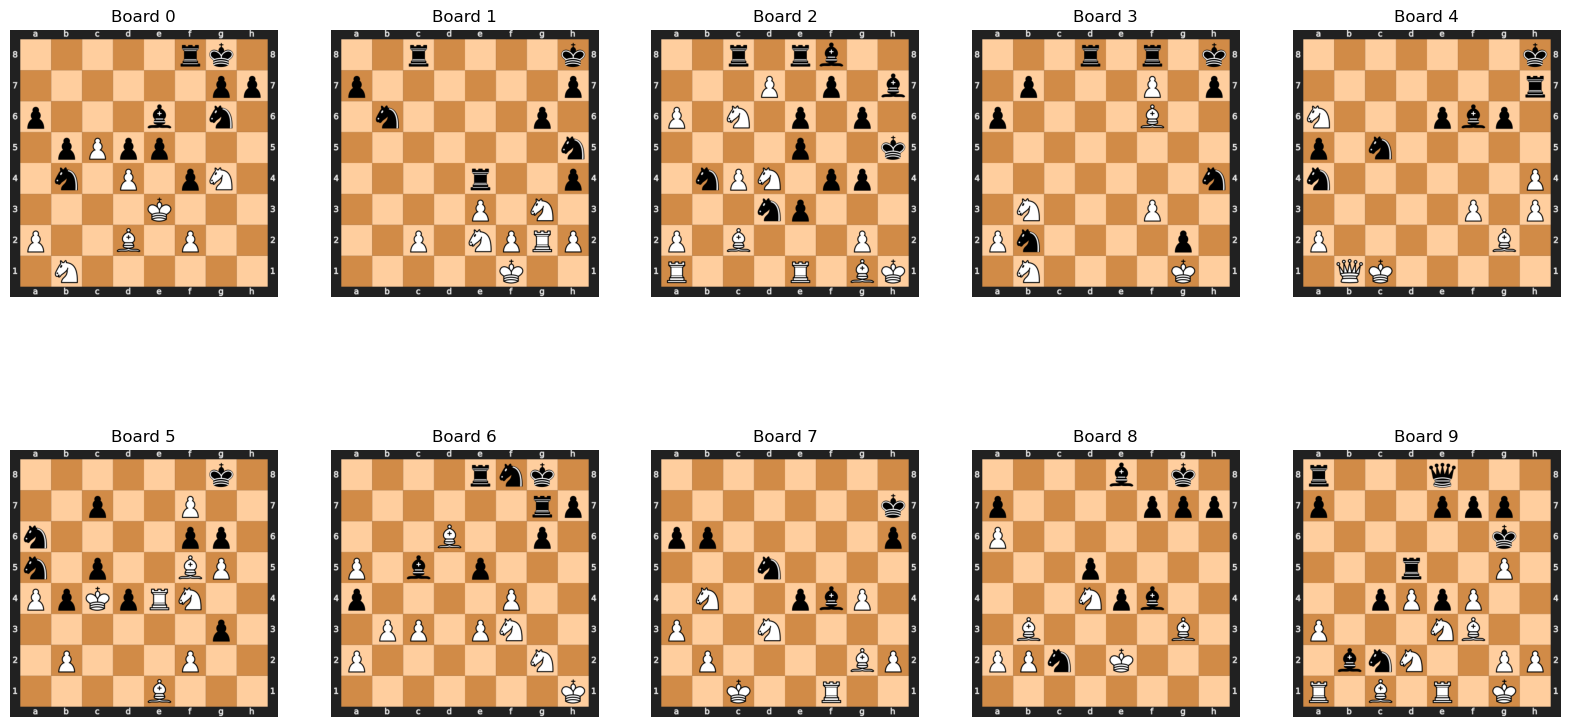

In [4]:
# we have a trained model now, lets generate some puzzles
import chess
import cairosvg
import numpy as np
import torch
from KaggleData.processKaggleData import decodeBoard
from matplotlib.image import imread
with torch.no_grad():
    print("Generating some boards")
    # start from pure noise for now
    ts = torch.zeros(10, dtype=torch.long) + ddpm.n_steps
    fake = ddpm.createFromNoise(10, ts.to(device), writeToGif=False).to('cpu')
    # reverse the z score on the fake
    # this is done in createFromNoise now
    #fake = fake * std + mean
    # create a 2x5 subfigure
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    for i in range(10):
        board = fake[i, :]
        board = torch.round(board, decimals=0)
        # add an empty dimension in front
        board = board.unsqueeze(0)
        board = decodeBoard(board)

        hmm = chess.svg.board(board=board, size=600)
        hmm = cairosvg.svg2png(bytestring=hmm)
        # write this to a file
        with open("./GeneratedBoards/boardFromNoise%d.png" % i, 'wb') as f:
            f.write(hmm)

        # lets also plot this board
        hmm = imread("./GeneratedBoards/boardFromNoise%d.png" % i, format='png')
        axs[i // 5, i % 5].imshow(hmm)
        axs[i // 5, i % 5].axis('off')
        # set title
        axs[i // 5, i % 5].set_title("Board %d" % i)
    plt.show()


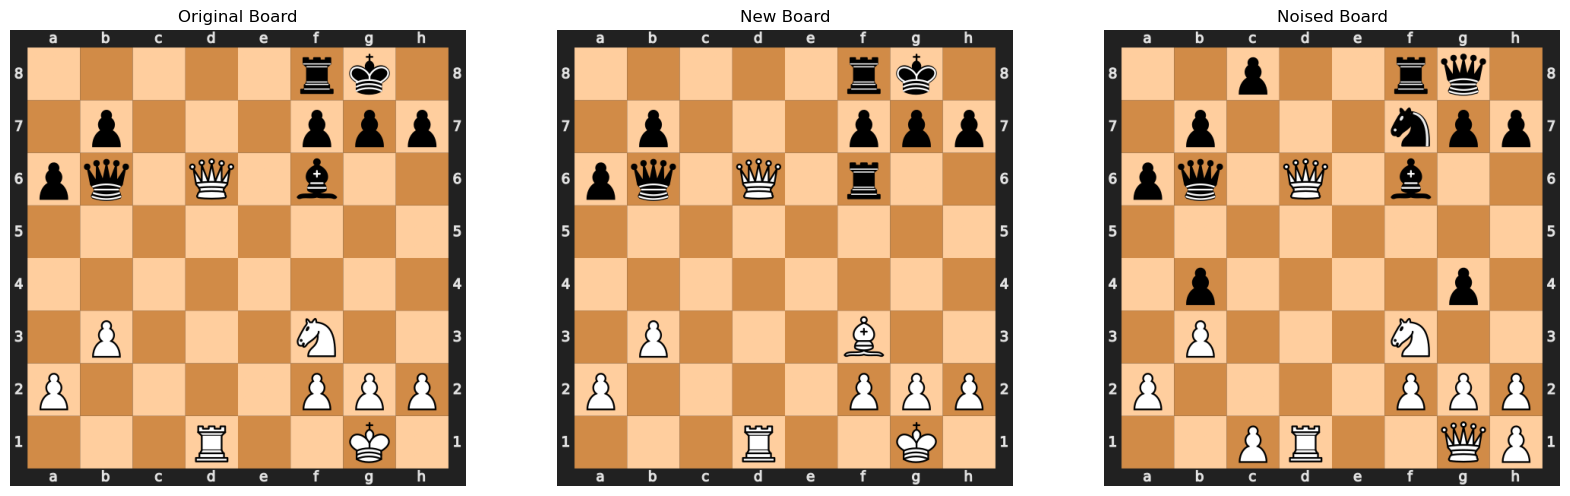

In [16]:
# Now create some puzzles by slightly disturbing an existing position

import chess
import cairosvg
import numpy as np
import torch
from KaggleData.processKaggleData import decodeBoard
from matplotlib.image import imread
import matplotlib.pyplot as plt

realBoard = trainBoardTensors[0, :]
realBoard = realBoard.unsqueeze(0)
newBoard, noisedBoard = ddpm.createFromReal(realBoard.to(device), 75)

newBoard = newBoard.to('cpu')
noisedBoard = noisedBoard.to('cpu')

# reverse the norm
realBoard = realBoard * std + mean
noisedBoard = noisedBoard * std + mean

# round them
realBoard = torch.round(realBoard, decimals=0)
noisedBoard = torch.round(noisedBoard, decimals=0)

realBoard = decodeBoard(realBoard)
newBoard = decodeBoard(newBoard)
noisedBoard = decodeBoard(noisedBoard)

hmm = chess.svg.board(board=realBoard, size=600)
hmm = cairosvg.svg2png(bytestring=hmm)
newHmm = chess.svg.board(board=newBoard, size=600)
newHmm = cairosvg.svg2png(bytestring=newHmm)
noisedHmm = chess.svg.board(board=noisedBoard, size=600)
noisedHmm = cairosvg.svg2png(bytestring=noisedHmm)
# lets display this
# write to a temp file just to read it back cuz reasons
with open("./GeneratedBoards/tmp.png", 'wb') as f:
    f.write(hmm)
hmm = imread("./GeneratedBoards/tmp.png", format='png')

with open("./GeneratedBoards/tmp.png", 'wb') as f:
    f.write(newHmm)
newHmm = imread("./GeneratedBoards/tmp.png", format='png')

with open("./GeneratedBoards/tmp.png", 'wb') as f:
    f.write(noisedHmm)
noisedHmm = imread("./GeneratedBoards/tmp.png", format='png')

# create a 1x3 subfigure
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(hmm)
axs[0].axis('off')
axs[0].set_title("Original Board")
axs[1].imshow(newHmm)
axs[1].axis('off')
axs[1].set_title("New Board")
axs[2].imshow(noisedHmm)
axs[2].axis('off')
axs[2].set_title("Noised Board")
plt.show()